In [61]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 10

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

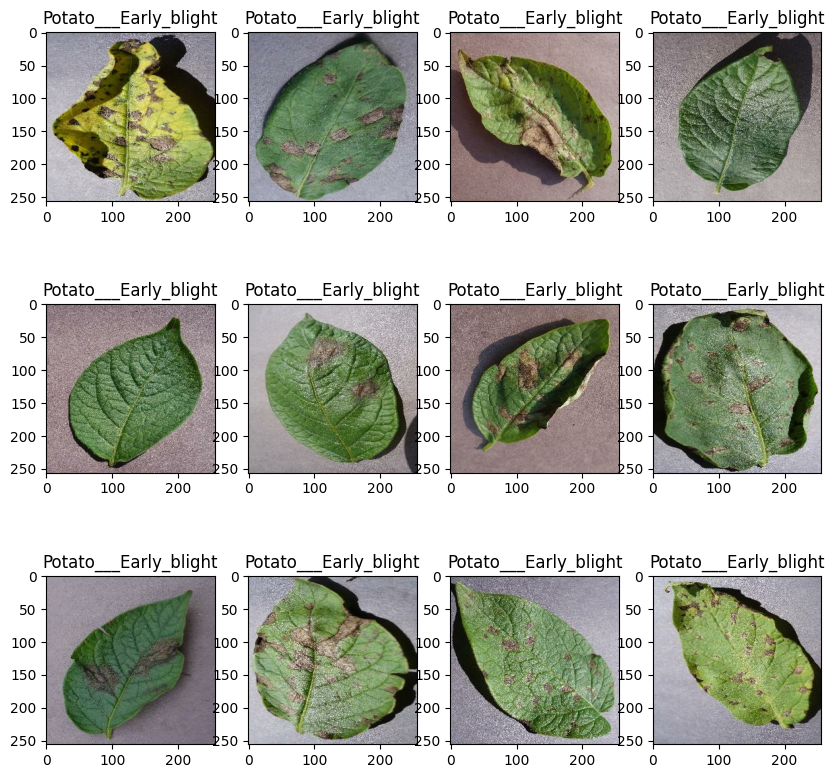

In [20]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
	for i in range(12):
		plt.subplot(3, 4, i+1)
		plt.title(class_names[label_batch[0]])
		plt.imshow(image_batch[i].numpy().astype("uint8"))

In [47]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
	ds_size = len(ds)
 
	if shuffle:
		ds = ds.shuffle(shuffle_size, seed=12)
  
	train_size = int(train_split * ds_size)
	val_size = int(val_split * ds_size)
	train_ds = ds.take(train_size)
	val_ds = ds.skip(train_size).take(val_size)
	test_ds = ds.skip(train_size).skip(val_size)
 
	return train_ds, val_ds, test_ds

In [48]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f'Training Length: {len(train_ds)}')
print(f'Validation Length: {len(val_ds)}')
print(f'Test Length: {len(test_ds)}')

Training Length: 54
Validation Length: 6
Test Length: 8


In [49]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
resize_and_rescale = tf.keras.Sequential([
	layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
	layers.experimental.preprocessing.Rescaling(1.0/255),
])


In [33]:
data_augmentation = resize_and_rescale = tf.keras.Sequential([
	layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
	layers.experimental.preprocessing.RandomRotation(0.2),
])

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_SIZE)
num_classes = 3

model = models.Sequential([
    #Preprocessing layers
    resize_and_rescale,
    data_augmentation,
    
    #Convolutional layers
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    #Dense layers
    layers.Dense(64, activation = "relu"),
    
    layers.Dense(num_classes, activation = "softmax"),

])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_24 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 64)       

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics='accuracy',
)

In [53]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 140s 3s/step - loss: 0.6613 - accuracy: 0.7101 - val_loss: 0.5147 - val_accuracy: 0.8229
Epoch 2/10
54/54 [==============================] - 122s 2s/step - loss: 0.4091 - accuracy: 0.8368 - val_loss: 0.4839 - val_accuracy: 0.8281
Epoch 3/10
54/54 [==============================] - 96s 2s/step - loss: 0.2925 - accuracy: 0.8826 - val_loss: 0.3291 - val_accuracy: 0.8490
Epoch 4/10
54/54 [==============================] - 97s 2s/step - loss: 0.2440 - accuracy: 0.8967 - val_loss: 0.2666 - val_accuracy: 0.9115
Epoch 5/10
54/54 [==============================] - 97s 2s/step - loss: 0.2578 - accuracy: 0.9032 - val_loss: 0.2145 - val_accuracy: 0.9271
Epoch 6/10
54/54 [==============================] - 95s 2s/step - loss: 0.2021 - accuracy: 0.9237 - val_loss: 0.3535 - val_accuracy: 0.8594
Epoch 7/10
54/54 [==============================] - 89s 2s/step - loss: 0.1740 - accuracy: 0.9354 - val_loss: 0.1318 - val_accuracy: 0.9323
Epoch 8/10
54/54 [

In [56]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 465ms/step - loss: 0.1788 - accuracy: 0.9297


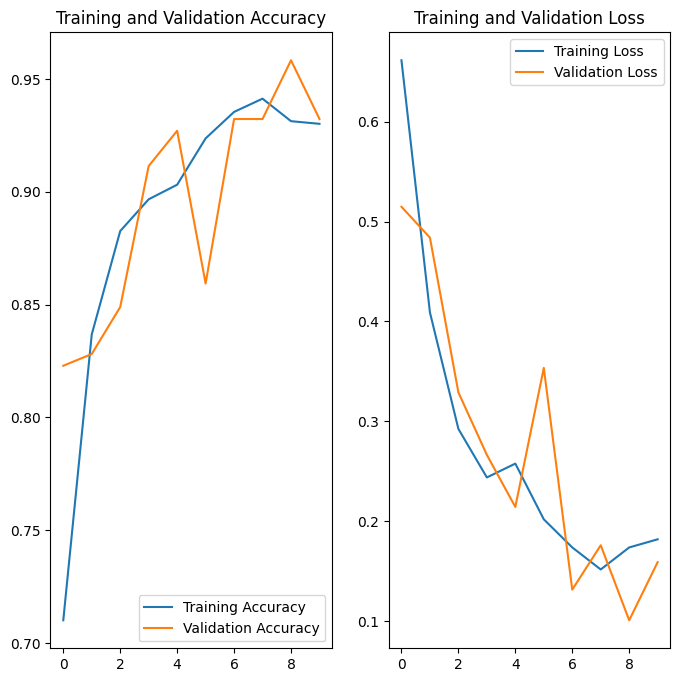

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
def predict(model, img):
	img_array = tf.keras.preprocessing.image.img_to_array(img)
	img_array = tf.expand_dims(img_array, 0) # Create a batch
 
	predictions = model.predict(img_array)
	predicted_class = class_names[np.argmax(predictions[0])]
	confidence = round(100 * (np.max(predictions[0])) , 2)
 
	return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


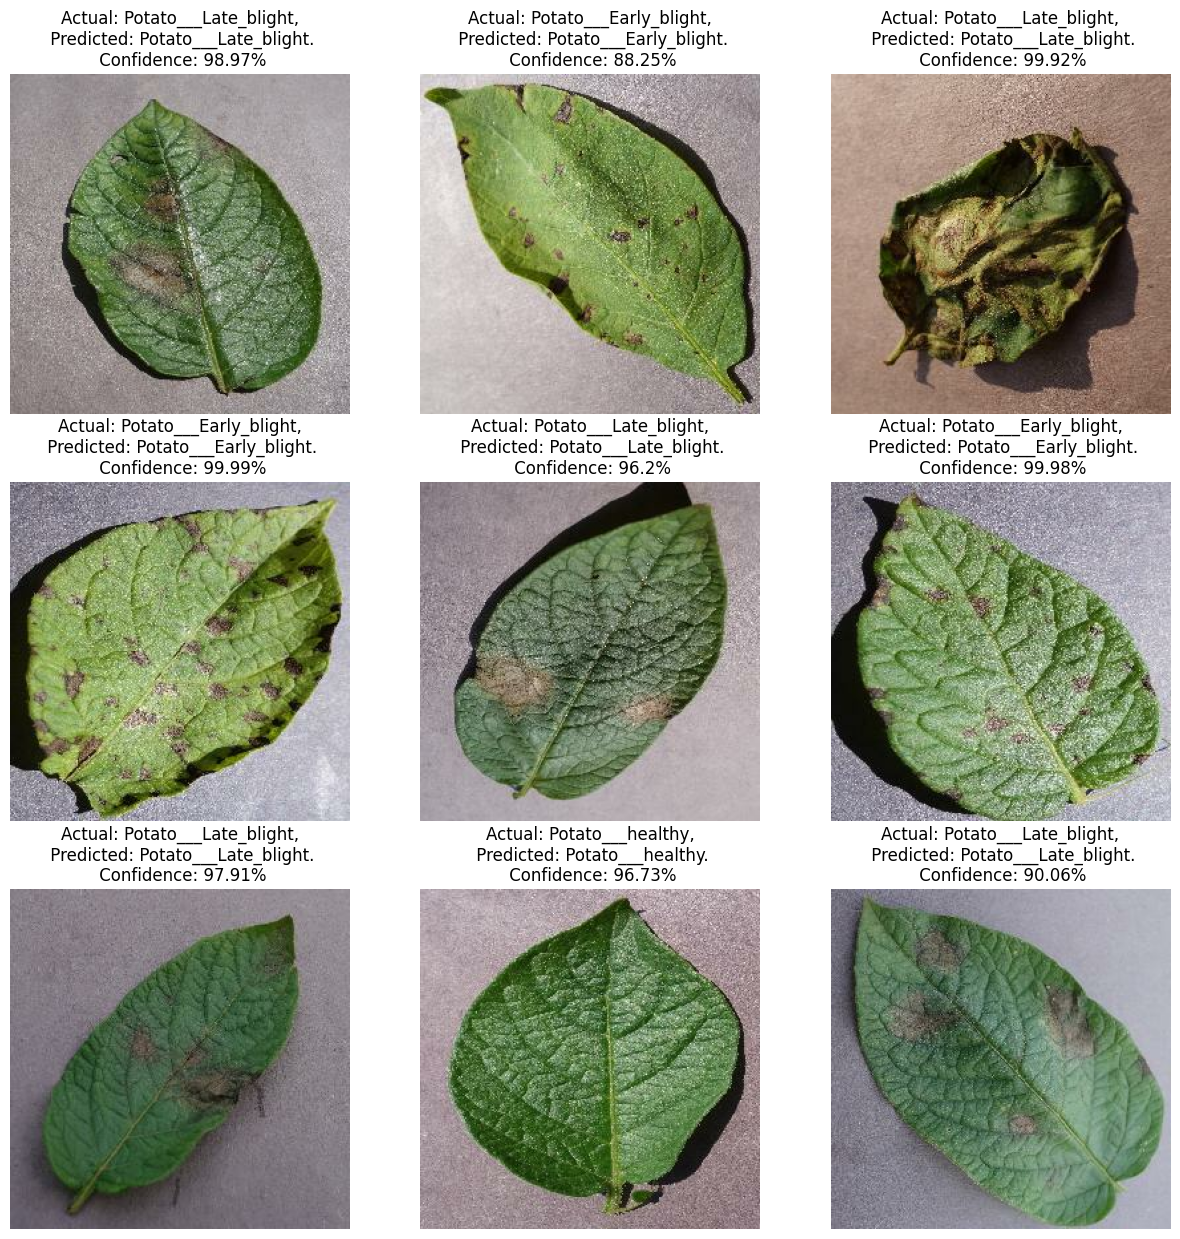

In [74]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [75]:
model_version=3
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets
